# StyleGAN latent space exploration 

## План:

1.Открыть изображения и нормализовать

2.Инициализировать функции потерь

3.Получить стартовую точку (пробовать разные способы: e4e, средний вектор, интерполяция между векторами)

4.Пробовать разные функции потерь, можно пробовать свои

5.Результат конкатенация трех картинок в одну target, source, swap



# Dependencies

In [ ]:
# !unzip celebs.zip
# !unzip editing.zip

In [ ]:
# !pip install ninja
# !pip install imageio-ffmpeg
# !pip install -U -q PyDrive
# !pip install lpips
# !pip install pytorch_msssim
# !pip install pytorch-ignite


# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# # Authenticate and create the PyDrive client.
# # This only needs to be done once per notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# %mkdir raw_images
# !git clone https://github.com/NVlabs/stylegan2-ada-pytorch
# %cd stylegan2-ada-pytorch
# !git clone https://github.com/denkogit/stylegan2_models



# !mkdir pretrained_models
# %cd /content/stylegan2-ada-pytorch/pretrained_models
# !wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
# !wget https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2
# !bzip2 -d /content/stylegan2-ada-pytorch/pretrained_models/shape_predictor_68_face_landmarks.dat.bz2

# file_id = '1cUv_reLE6k3604or78EranS7XzuVMWeO' # URL id. 
# downloaded = drive.CreateFile({'id': file_id})
# downloaded.GetContentFile('e4e_ffhq_encode.pt')

# file_id = '1QIPdkYyIwqEUS8jBNouWo9eYzr3DwDd5' # URL id. 
# downloaded = drive.CreateFile({'id': file_id})
# downloaded.GetContentFile('ms1mv3_arcface_r50_fp16.pth')

# %cd ..

# # ref https://github.com/Puzer/stylegan-encoder/blob/master/align_images.py
# !git clone https://github.com/omertov/encoder4editing


/content
Cloning into 'encoder4editing'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 172 (delta 6), reused 15 (delta 6), pack-reused 156
Receiving objects: 100% (172/172), 33.44 MiB | 25.63 MiB/s, done.
Resolving deltas: 100% (51/51), done.


# StyleGAN face generating

## StyleGAN - generating from noise

In [ ]:
device = "cuda:0"
model_path = "/content/stylegan2-ada-pytorch/pretrained_models/ffhq.pkl"

import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


def plot_image(tensor, plot_size=(10,10)):
  tensor = (tensor.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  img = Image.fromarray(tensor[0].cpu().numpy(), 'RGB')
  plt.rcParams["figure.figsize"] = plot_size
  plt.imshow(img)


def broadcast_w_sg(w_batch, cast_n=18):
    input_ws = []
    for w in w_batch:   
        w_broadcast = torch.broadcast_to(w, (cast_n, 512))
        input_ws.append(w_broadcast)
    return torch.stack(input_ws)


with open(model_path, 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()

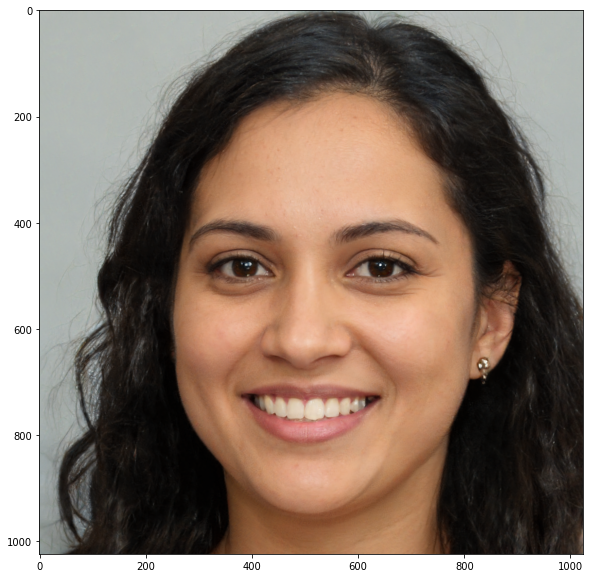

In [ ]:
# сгенерим из шума

seed = 100
noise_mode = 'const' # шум постоянный
label = 0 # для разных моделей

z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(device)
ws = G.mapping(z, label, truncation_psi=(0.5))
generated_tensor = G.synthesis(ws, noise_mode=noise_mode, force_fp32=True)
plot_image(generated_tensor)


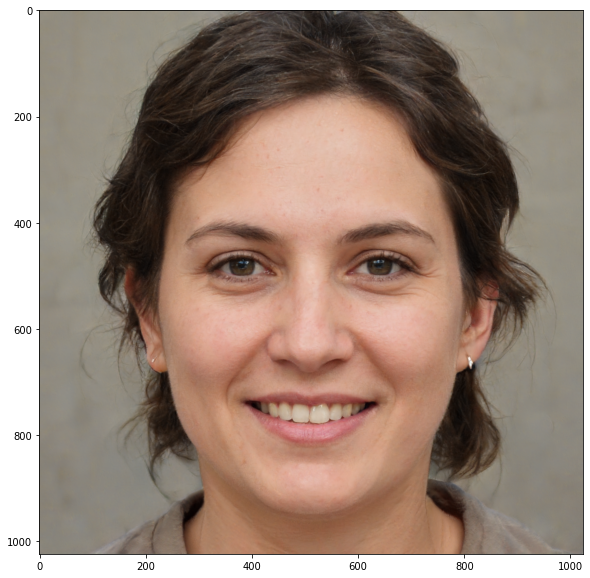

In [ ]:
# изменим truncation_psi на 0.1 для интереса

seed = 100
noise_mode = 'const' # шум постоянный
label = 0 # для разных моделей

z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(device)
ws = G.mapping(z, label, truncation_psi=(0.1))
generated_tensor = G.synthesis(ws, noise_mode=noise_mode, force_fp32=True)
plot_image(generated_tensor)


## Aligning of images

In [ ]:
import os 
from stylegan2_models.image_aligner.face_alignment import image_align
from stylegan2_models.image_aligner.landmarks_detector import LandmarksDetector


landmarks_model_path = "/content/stylegan2-ada-pytorch/pretrained_models/shape_predictor_68_face_landmarks.dat"
RAW_IMAGES_DIR = "/content/celebs/"
ALIGNED_IMAGES_DIR = "/content/aligned_images/"

landmarks_detector = LandmarksDetector(landmarks_model_path)
for celeb in os.listdir(RAW_IMAGES_DIR):
  celeb_folder = os.path.join(RAW_IMAGES_DIR, celeb)
  save_path = os.path.join(ALIGNED_IMAGES_DIR, celeb)
  os.makedirs(save_path, exist_ok=True)

  for i, img_name in enumerate(os.listdir(celeb_folder)):
      if img_name == ".ipynb_checkpoints":
        continue
      raw_img_path = os.path.join(celeb_folder, img_name)
      for face_landmarks in landmarks_detector.get_landmarks(raw_img_path):
          aligned_face_path = os.path.join(save_path, f"{i}.jpg")
          image_align(raw_img_path, aligned_face_path, face_landmarks)
          break

## Projection of real images 

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/vgg.pth
0.5327228903770447


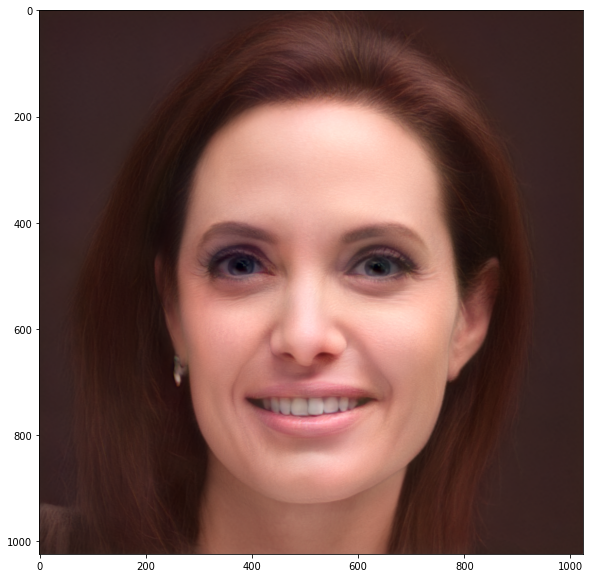

In [ ]:
import PIL
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import lpips
from pytorch_msssim import ms_ssim



#-------------------------------------------#
# Добавим другую функцию потерь - Additive Angular Margin Loss for Deep Face Recognition

'''The ArcFace loss maximizes the margin, \
i.e. the decision boundary at the geodesic space on the hypersphere thanks \
to the normalized weights and features. It obtains highly discriminative features \
for face recognition and can be easily implemented with negligible computational overhead.'''

# #-------------------------------------------#

class Arcface_Loss(nn.Module):
    def __init__(self, weights_path, device):
        super().__init__()

        self.arcnet = get_model("r50", fp16=False)
        self.arcnet.load_state_dict(torch.load(weights_path))
        self.arcnet.eval()
        self.arcnet.to(device)
    
        self.cosin_loss = nn.CosineSimilarity(dim=1, eps=1e-6)
      
    def forward(self, source, synth):

        source = F.interpolate(source,size=(112,112), mode='bicubic')
        synth = F.interpolate(synth,size=(112,112), mode='bicubic')

        emb1 = self.arcnet(source)
        emb2 = self.arcnet(synth)
        loss = (1 - self.cosin_loss(emb1, emb2))[0]
        return loss


class Lpips_loss(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.lpips_loss = lpips.LPIPS(net='vgg')
        self.lpips_loss.to(device)
        self.lpips_loss.eval()
      
    def forward(self, target, synth):
        return torch.mean(self.lpips_loss(target, synth))

    
def image2tensor_norm(image):
    transform = transforms.Compose([transforms.ToTensor(), 
                                   transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    tensor = transform(image)
    return tensor



#-------------------------------------------#
# загружаем изображение - А. Джоли
#-------------------------------------------#
inv_img_path = "/content/aligned_images/AJoly/0.jpg"
target_pil = PIL.Image.open(inv_img_path).convert('RGB')
target_tensor = image2tensor_norm(target_pil).to(device).unsqueeze(0)



#-------------------------------------------#
# инициализируем функции потерь  - выберем Additive Angular Margin Loss + "perceptual loss"
# arcface_path = "/content/stylegan2-ada-pytorch/ms1mv3_arcface_r50_fp16.pth"
#-------------------------------------------#
w_path_Arcface_Loss="/content/stylegan2-ada-pytorch/ms1mv3_arcface_r50_fp16.pth"
arc_loss=Arcface_Loss(w_path_Arcface_Loss, device) # "perceptual loss"
lpips = Lpips_loss(device)


#-------------------------------------------#
# Параметры для оптимизации
# 1.сделаем побольше шагов
# 2.понизим learning rate
#-------------------------------------------#

num_steps = 700
seed = 100
initial_learning_rate = 0.05
w_avg_samples = 10000


# средний вектор латентного пространства - Compute w stats
z_samples = torch.from_numpy(np.random.RandomState(seed).randn(w_avg_samples, G.z_dim)).to(device)
w_samples = G.mapping(z_samples, None)
w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32) 
w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 1, C]
w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5


#-------------------------------------------#
# cтартовая точка - Features for target image.
# w_plus vector with broadcast_w_sg()
#-------------------------------------------#
w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=False) 
w_opt = broadcast_w_sg(w_opt).requires_grad_(True)
optimizer = torch.optim.Adam([w_opt], lr=initial_learning_rate)


for step in range(num_steps):
  synth_tensor = G.synthesis(broadcast_w_sg(w_opt), noise_mode='const')

  arc_loss = arc_loss(synth_tensor, target_tensor)
  lpips_loss = lpips(synth_tensor, target_tensor)

  loss = lpips_loss + arc_loss

  optimizer.step()
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  

generated_tensor = G.synthesis(broadcast_w_sg(w_opt), noise_mode='const', force_fp32=True)
plot_image(generated_tensor)
print(loss.item())

### Encoder for editing

In [ ]:
from stylegan2_models.e4e.model_utils import load_e4e_standalone
import torchvision.transforms as transforms

e4e_model, _ = load_e4e_standalone("/content/stylegan2-ada-pytorch/pretrained_models/e4e_ffhq_encode.pt")

image2e4etensor = transforms.Compose([transforms.ToTensor(), 
                                transforms.Resize((256, 256)),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])


In [ ]:
#-----------------------------------#
              # target #
#-----------------------------------#

image_path = "/content/aligned_images/EMerphy/0.jpg"
target_pil = Image.open(image_path).convert('RGB')
target_uint8 = np.array(target_pil, dtype=np.uint8)

e4e_tensor = image2e4etensor(target_uint8).to(device).unsqueeze(0)
initial_latent_vector = e4e_model(e4e_tensor)

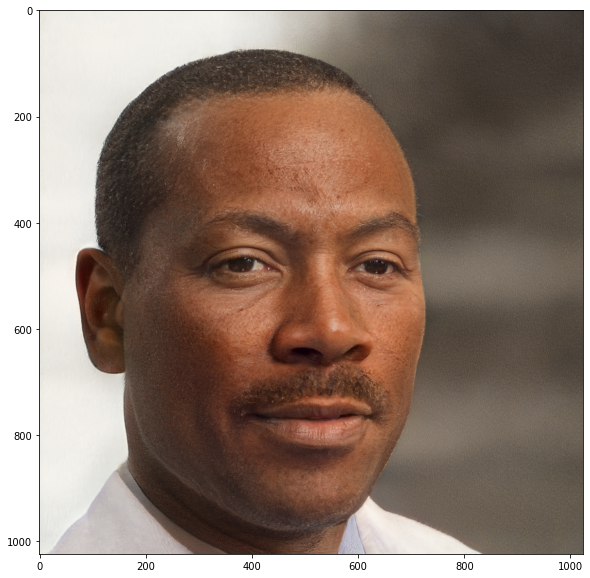

In [ ]:
generated_tensor = G.synthesis(initial_latent_vector, noise_mode='const', force_fp32=True)
plot_image(generated_tensor)

## Plot latent with PCA

In [ ]:
###     Only for Merphy :)    ###

import os
import glob
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox



images_path = "/content/aligned_images"
save_path = "/content/e4e_invertion"

data = []

for persone in sorted(os.listdir(images_path)):
    if persone.endswith(".jpg"):
        person_images = os.path.join(images_path, persone)
        save_folder = os.path.join(save_path, persone)
        os.makedirs(save_folder, exist_ok=True)


    for image_name in os.listdir(person_images):
      if image_name.endswith(".jpg"):
        image_path = os.path.join(person_images, image_name)

        target_pil = Image.open(image_path).convert('RGB')
        target_uint8 = np.array(target_pil, dtype=np.uint8)

        e4e_tensor = image2e4etensor(target_uint8).to(device).unsqueeze(0)
      
        latent_vector = e4e_model(e4e_tensor).detach().cpu()
        latent_path = os.path.join(save_folder, f"{image_name[:-3]}.pt")

        torch.save(latent_vector, latent_path)
        data.append([persone, image_name, image_path, latent_path])


df = pd.DataFrame(data, columns = ['key', 'image_name', 'image_path', 'latent_path'])

Здесь я реализовала кластеризацию только для Мерфи

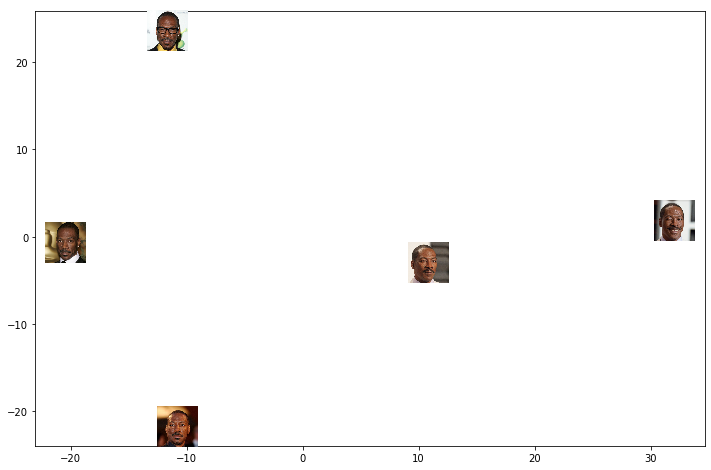

In [ ]:
def getImage(path, zoom=0.04):
    return OffsetImage(plt.imread(path), zoom=zoom)

embedings = []
for index, row in df.iterrows():
    latent_path = row["latent_path"]
    latent = torch.load(latent_path).numpy().squeeze(0)
    embedings.append(latent)


batch = np.stack(embedings, axis=0)
batch = batch.reshape((25, 9216))
pca = PCA(n_components=2, random_state=22).fit(batch)
x = pca.transform(batch)


fig, ax = plt.subplots(figsize=(12,8))
# for x, y, path in zip(x[:, 0], x[:, 1], df.image_path.values.tolist()):
for x, y, df_iter in zip(x[:, 0], x[:, 1], df.iterrows()):
  i, row = df_iter
  path = row["image_path"]
  label = row["key"]
  ab = AnnotationBbox(getImage(path), (x, y), frameon=False)
  ax.add_artist(ab) 
  plt.scatter(x,y, label=label)

plt.show()




## Интерполяция

In [ ]:
from IPython.display import display, FileLink
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import torch

def interpolate(latent1, latent2, psi=0.5):
    latent1 = latent1.clone()
    latent2 = latent2.clone()
    indeces = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
    #----------------------------#
    # сначала возьмем все индексы
    #----------------------------#
    for i in indeces:
        latent1[:, i] = latent2[:, i].lerp(latent1[:, i], psi)
    
    generated_tensor = G.synthesis(latent1, noise_mode='const', force_fp32=True)
    plot_image(generated_tensor)



latent1=torch.load("/content/e4e_invertion/EMerphy/0..pt").to(device)
#----------------------------#
# изменим на фокус на улыбку#
#----------------------------#
latent2=torch.load("/content/editing/smile.pt").to(device)

interactive(interpolate, latent1=fixed(latent1), latent2=fixed(latent2), 
            psi=widgets.FloatSlider(value=0.5, min=-1.0, max=1.0, step=0.1))

interactive(children=(FloatSlider(value=0.5, description='psi', max=1.0, min=-1.0), Output()), _dom_classes=('…

In [ ]:
from IPython.display import display, FileLink
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import torch



def interpolate(latent1, latent2, psi=0.5):
    latent1 = latent1.clone()
    latent2 = latent2.clone()
    indeces = [0,1,2,3,4,5]
    #----------------------------#
    # другие индексы
    #----------------------------#
    for i in indeces:
        latent1[:, i] = latent2[:, i].lerp(latent1[:, i], psi)
    
    generated_tensor = G.synthesis(latent1, noise_mode='const', force_fp32=True)
    plot_image(generated_tensor)



latent1=torch.load("/content/e4e_invertion/EMerphy/1..pt").to(device)
#----------------------------#
# изменим на фокус на age#
#----------------------------#
latent2=torch.load("/content/editing/age.pt").to(device)

interactive(interpolate, latent1=fixed(latent1), latent2=fixed(latent2), 
            psi=widgets.FloatSlider(value=0.5, min=-1.0, max=1.0, step=0.1))

interactive(children=(FloatSlider(value=0.5, description='psi', max=1.0, min=-1.0), Output()), _dom_classes=('…

In [ ]:
from IPython.display import display, FileLink
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import torch



def interpolate(latent1, latent2, psi=0.5):
    latent1 = latent1.clone()
    latent2 = latent2.clone()
    indeces = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
    #----------------------------#
    # сначала возьмем все индексы
    #----------------------------#
    for i in indeces:
        latent1[:, i] = latent2[:, i].lerp(latent1[:, i], psi)
    
    generated_tensor = G.synthesis(latent1, noise_mode='const', force_fp32=True)
    plot_image(generated_tensor)



latent1=torch.load("/content/e4e_invertion/AJoly/3..pt").to(device)
#----------------------------#
# изменим на фокус на улыбку#
#----------------------------#
latent2=torch.load("/content/editing/smile.pt").to(device)

interactive(interpolate, latent1=fixed(latent1), latent2=fixed(latent2), 
            psi=widgets.FloatSlider(value=0.5, min=-1.0, max=1.0, step=0.1))


interactive(children=(FloatSlider(value=0.5, description='psi', max=1.0, min=-1.0), Output()), _dom_classes=('…

In [ ]:
from IPython.display import display, FileLink
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import torch



def interpolate(latent1, latent2, psi=0.5):
    latent1 = latent1.clone()
    latent2 = latent2.clone()
    indeces = [13,14,15,16,17]
    #----------------------------#
    #поэкспериментируем с индексами
    #----------------------------#
    for i in indeces:
        latent1[:, i] = latent2[:, i].lerp(latent1[:, i], psi)
    
    generated_tensor = G.synthesis(latent1, noise_mode='const', force_fp32=True)
    plot_image(generated_tensor)



latent1=torch.load("/content/e4e_invertion/AJoly/3..pt").to(device)
#----------------------------#
# изменим editing на возраст #
#----------------------------#
latent2=torch.load("/content/editing/pose.pt").to(device)

interactive(interpolate, latent1=fixed(latent1), latent2=fixed(latent2), 
            psi=widgets.FloatSlider(value=0.5, min=-1.0, max=1.0, step=0.1))

interactive(children=(FloatSlider(value=0.5, description='psi', max=1.0, min=-1.0), Output()), _dom_classes=('…